# **<노드 실습>**

## **노드 5 - 미니프로젝트: 시계열 분류**

## 프로젝트 목표
- 1) 비정상 데이터를 정상데이터로 만들기 -> AirPassengers.csv 데이터 활용
- 2) 강의에 활용됐던 분류 모델 성능 높이기 -> 사이킷런 내장 robot_execution_failures 데이터 활용

### 1) 비정상 데이터를 정상 데이터로 만들기

In [2]:
# 라이브러리를 불러옵니다.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd

url = '/content/AirPassengers.csv'
ap = pd.read_csv(url)

print(ap.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


- 비정상 시계열을 정상 시계열로 만드는데 'Month' 컬럼은 필요 없으므로 삭제한다.

In [4]:
ap = ap.drop('Month', axis=1) # 'Month' column을 삭제한다.

In [5]:
ap

#Passengers
0            112
1            118
2            132
3            129
4            121
..           ...
139          606
140          508
141          461
142          390
143          432

[144 rows x 1 columns]

- matplotlib을 통해서 AirPassengers 데이터를 그려서 확인한다.

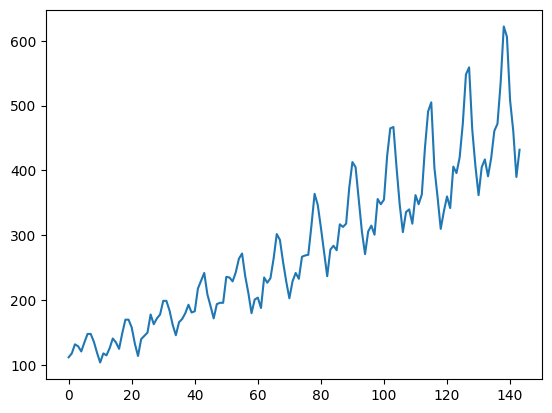

In [6]:
plt.figure()
plt.plot(ap)
plt.show()

- 위 그래프가 상승하는 추세이고, 점점 분산이 커지므로 완벽한 비정상 데이터이다. -> 분산을 줄이고, 증가하는 추세를 제거하면 정상 시계열 데이터를 얻을 수 있을것이다!

### 2) 분산을 일정하게 만들기 -> 로그변환

In [7]:
log_transformed = np.log(ap) # np.log를 통해 로그변환한다.

In [8]:
log_transformed

#Passengers
0       4.718499
1       4.770685
2       4.882802
3       4.859812
4       4.795791
..           ...
139     6.406880
140     6.230481
141     6.133398
142     5.966147
143     6.068426

[144 rows x 1 columns]

- 그럼, 분산이 일정해졌는지 그래프를 통해 확인해본다.

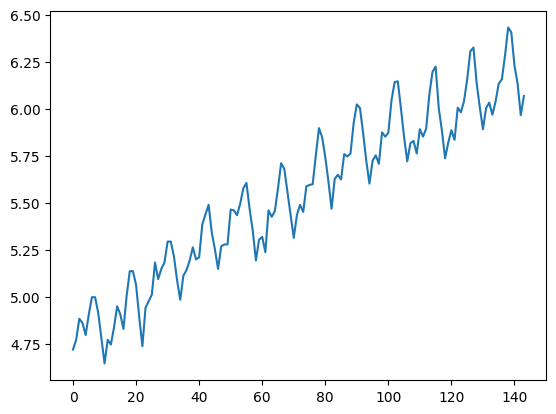

In [9]:
plt.figure()
plt.plot(log_transformed)
plt.show()

- 위 그래프에서, 로그변환 전에는 증가했던 분산이, 로그변환을 통해서 분산이 일정하게 만들어진 것을 확인할 수 있다.

### 3) 차분을 통해 추세 제거하기
- 차분을 진행하면 데이터가 짧아지기 때문에, 데이터를 잘라서 쓰거나 or 없어진 데이터에 널값이 들어가는데, 널값을 제거해야한다.

In [10]:
diffed = log_transformed.diff() # diff() 함수를 통해 간단하게 차분을 수행한다.

In [11]:
diffed

#Passengers
0            NaN
1       0.052186
2       0.112117
3      -0.022990
4      -0.064022
..           ...
139    -0.026060
140    -0.176399
141    -0.097083
142    -0.167251
143     0.102279

[144 rows x 1 columns]

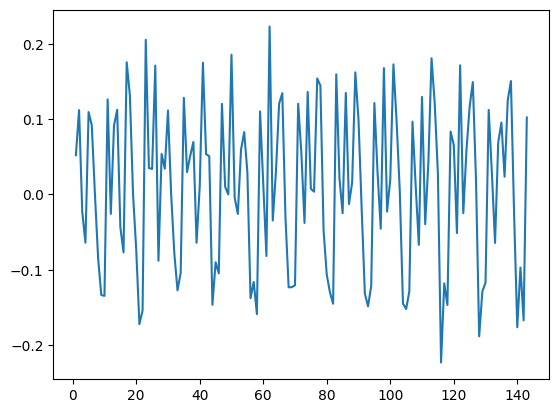

In [12]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있다.
plt.figure()
plt.plot(diffed)
plt.show()

- 위 그래프에서, 평균이 0이고 분산이 더이상 커지지 않는 데이터를 얻을 수 있다.


#### cf) 계절 차분을 통해 계절성 제거하기
- AirPassengers 데이터는 12개월을 주기로 하는 계절성이 포함되어 있음 -> 이 경우에, 계절 차분을 통해서 계절성을 데이터에서 제거할 수 있다!
- 계절 차분은 12개월 전과의 차이를 계산한다.

In [13]:
seasonally_diffed = diffed.diff(12) # diff=12: 주기를 12로 하는 계절 차분 -> 같은 달(12개월 전)의 변화량을 비교함
seasonally_diffed.dropna(inplace = True) # 차분을 하면 데이터가 짧아지기 때문에 널값을 제거해야한다.

## 어떤것을 dropna 한다는 말이지? -> diffed[t] - diffed[t-12]를 계산하는데, 처음 12개 항목은 t-12라는 값이 존재하지 않는 널값인 상태이므로, 이 값을 제거해야 한다는 의미임!

In [14]:
seasonally_diffed

#Passengers
13      0.039164
14      0.000361
15     -0.020496
16     -0.012939
17      0.066148
..           ...
139    -0.045934
140     0.012024
141     0.031830
142    -0.050082
143    -0.009964

[131 rows x 1 columns]

- 이제, 위에서 계절 차분까지 진행한 데이터를 시각화 해본다.

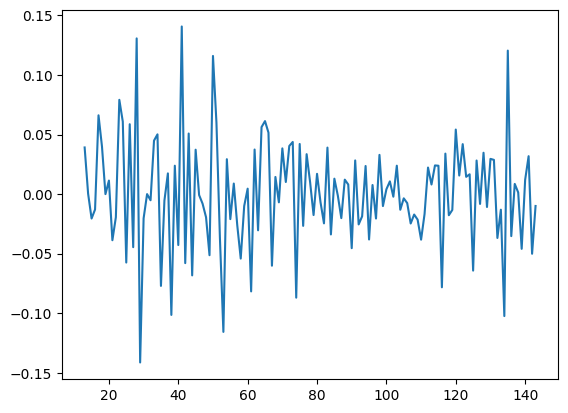

In [15]:
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

- 위 그래프를 통해서 시계열 데이터가 정상성을 띠는지, 아닌지는 '검정'을 통해 알아봐야 한다.
- 이제, ADF 검정을 통해 시계열 데이터의 정상성을 확인해본다.

### 4) 검정을 통해 정상성 확인하기
- ADF 검정을 수행한다.
  - adfuller 함수 이용한다.

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # ADF 검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용 -> 6가지 output이 출력된다.
    print('ADF statistics')
    print(stat) # ADF 검정 통계량
    print('P-value')
    print(p_value) # P-value

In [17]:
adf_test(seasonally_diffed) # 계절차분까지 수행한 데이터로 ADF 검정을 진행한다.

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


- 위의 결과, 계절 차분까지 진행한 데이터에서 유의수준 0.01에서 단위근이 존재한다라는 귀무가설(H0)을 기각하고, 시계열은 정상적이다라는 대립가설(H1)을 채택한다.
- 지금까지의 과정을 통해 비정상 시계열 데이터를 정상 시계열 데이터로 만들었다.
- if) ADF 검정 or KPSS 검정을 진행하여 시계열 데이터가 정상성을 만족하지 않는다는 판단을 했다면 어떻게 해야할까?
  - 1) 더 높은 차분 차수 적용 -> ex) 2차 차분을 고려함
  - 2) 다른 계절성 주기를 확인함 -> ex) 데이터 시각화를 진행하였더니, 12개월이 아니라 6개월임
  - 3) 로그변환 외의 다른 변환을 적용함 -> ex) 루트를 씌움

##### cf) **[개인학습]** 모델 학습하고 -> 예측하고 -> 모델 평가 진행하기
- AirPassengers 시계열 데이터는 원래 추세 + 계절성 + 증가하는 분산 존재 -> 비정상 시계열 데이터이다.
- 이 데이터를 로그변환 -> 차분 -> 계절 차분 과정을 통해 정상 시계열 데이터로 변환했다.
- 이제, ARIMA와 같은 선형시계열모델을 활용할 수 있는 조건을 갖췄으므로, ARIMA 모델을 학습한다!
  - ARIMA (AutoRegressive Integrated Moving Average)란?
    - AR(AutoRegressive) 모델: 과거의 관측값을 기반으로, 현재값을 예측 (자기회귀)
    - I(Integrated) 모델: 시계열을 차분(diff)해서 정상성을 확보
    - MA(Moving Average) 모델: 과거의 예측 오차를 활용해서 현재값을 예측
  - ex) ARIMA(1,1,1) → 1차 자기회귀 + 1차 차분 + 1차 이동평균

In [92]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p,d,q) → (자기회귀, 차분, 이동평균)
model = ARIMA(log_transformed, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# 예측
forecast_log = model_fit.forecast(steps=12)
forecast_log

144    6.111696
145    6.055826
146    6.177926
147    6.200513
148    6.236277
149    6.372402
150    6.511515
151    6.509847
152    6.329073
153    6.212333
154    6.068787
155    6.172955
Name: predicted_mean, dtype: float64

- 위에서 예측한 값은 미래 12개월의 예측된 '로그값' 이므로, 로그값을 지수를 취해 원래 승객수로 복원한다.

In [94]:
forecast_exp = np.exp(forecast_log)
print(forecast_exp)

144    451.103337
145    426.591119
146    481.991069
147    493.002021
148    510.952669
149    585.462612
150    672.845027
151    671.723746
152    560.636913
153    498.863902
154    432.156177
155    479.601144
Name: predicted_mean, dtype: float64


- 이제, 예측 결과와 실제 데이터를 동일한 그래프에 시각화 해본다.

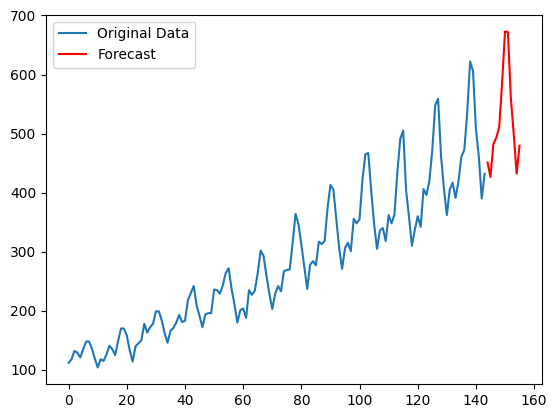

In [96]:
plt.plot(np.exp(log_transformed), label="Original Data") # 실제 데이터
plt.plot(forecast_exp, label="Forecast", color='red') # 예측 결과 데이터
plt.legend()

plt.show()

- 대략 이런식으로 시각화가 되었다..

### 5) 시계열 분류 진행하기

#### 1) 데이터 확인하기

In [18]:
# 1: 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터를 불러온다.
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [19]:
# 2: 데이터셋 확인 -> timeseries와 y 확인
timeseries # id, time을 제외하고 6개 column의 X변수가 나타난다.

id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns]

In [20]:
y # True/False가 제시되어 있다.

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

- id, time을 제외하고 6개 column의 X변수가 나타난다.
  - F_x, F_y.. 는 id, time에 따른 데이터
- y값으로는 True/False

#### 2) 데이터셋 가공하기
- 이제, id를 기준으로 데이터셋을 구분하기 위해 커스텀 함수를 만든다.



In [21]:
# 3: 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3): # custom split 함수

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list) # y에서 id_list를 제거한다.
    y_test = y.iloc[id_list].sort_index() # 19~38, 1~6이 합쳐진 리스트를 정렬한다.
    X_train = x[~x['id'].isin(id_list)] # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고, 물결표시는 안에 조건이 포함되어 있지 않는것만 사용한다.
    X_test = x[x['id'].isin(id_list)] # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용한다.

    return X_train, y_train, X_test, y_test

#### 3) 데이터셋 분리하기
- 그 다음, 데이터셋을 train:test = 8:2로 나눈다.

In [22]:
# 4: 데이터셋 나누기
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25) # test set의 비율을 0.25로 지정한다.

#### 4) 피처 추출하기(Feature extraction)
- EfficientParameters는 큰 계산 비용이 필요한 calculator를 제외하고 가능한 모든 특징을 생성한다.

In [23]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute # impute는 간단하게 널값을 정리해주는 역할을 한다.

settings = EfficientFCParameters()

In [24]:
# 5: 피처 추출하기 (Feature extraction)
comprehensive_features_train = extract_features(
                                    X_train,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:36<00:00, 11.12it/s]


In [25]:
comprehensive_features_test = extract_features(
                                    X_test,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:11<00:00, 11.36it/s]


#### 5) impute
- impute를 통해 간단히 데이터 전처리를 진행한다.

In [26]:
# 6: impute
impute(comprehensive_features_train)

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
6                                            1.0                     1.0   
7                                            0.0                     1.0   
8                                            1.0                     0.0   
9                                            1.0                     0.0   
10                                           0.0                     0.0   
..                                           ...                     ...   
84                                           1.0                     1.0   
85                                           1.0                     0.0   
86                                           1.0                     0.0   
87                                           1.0                     1.0   
88                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
6                      1.0                 1.0            -15.0   
7                      0.0                 1.0            -13.0   
8                      1.0                 1.0            -10.0   
9                      0.0                 1.0            -10.0   
10                     1.0                 1.0            -14.0   
..                     ...                 ...              ...   
84                     0.0                 1.0          -1073.0   
85                     1.0                 1.0            143.0   
86                     0.0                 0.0            961.0   
87                     0.0                 1.0           4509.0   
88                     1.0                 1.0           -143.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
6              39.0              1.714286          0.142857   
7              21.0              0.928571          0.214286   
8              26.0              1.142857         -0.142857   
9              24.0              1.428571          0.000000   
10             14.0              0.142857          0.000000   
..              ...                   ...               ...   
84          96833.0              7.142857         -5.428571   
85           1683.0              1.357143          1.071429   
86          83497.0              9.071429          9.071429   
87        1405437.0             12.928571         12.214286   
88           1427.0              0.785714         -0.500000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
6                              0.153846         -1.0  ...   
7                             -0.076923         -1.0  ...   
8                              0.192308         -1.0  ...   
9                             -0.076923         -1.0  ...   
10                             0.000000         -1.0  ...   
..                                  ...          ...  ...   
84                            -0.038462        -98.0  ...   
85                             0.076923          8.0  ...   
86                             0.807692         52.0  ...   
87                            -1.038462        338.0  ...   
88                             0.038462         -9.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
6                       0.974315                       1.213008   
7                       1.255482                       1.494175   
8                       1.494175                       1.732868   
9                       1.255482                       1.494175   
10                      0.937285                       1.213008   
..                           ...                            ...   
84                      0.735622                       0.735622   
85                      0.735622                       0.735622   
86                      0.735622                       1.073543   
87                      0.735622                       0.735622   
88                      1.255482                       1.49

In [27]:
impute(comprehensive_features_test)

/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                            0.0                     0.0   
2                                            0.0                     1.0   
3                                            0.0                     0.0   
4                                            0.0                     1.0   
5                                            0.0                     0.0   
19                                           1.0                     0.0   
20                                           1.0                     0.0   
21                                           1.0                     0.0   
22                                           1.0                     0.0   
23                                           1.0                     0.0   
24                                           1.0                     0.0   
25                                           1.0                     0.0   
26                                           1.0                     0.0   
27                                           1.0                     1.0   
28                                           1.0                     0.0   
29                                           1.0                     0.0   
30                                           1.0                     0.0   
31                                           1.0                     0.0   
32                                           1.0                     0.0   
33                                           1.0                     0.0   
34                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                      1.0                 1.0            -14.0   
2                      1.0                 1.0            -13.0   
3                      1.0                 1.0            -10.0   
4                      1.0                 1.0             -6.0   
5                      0.0                 1.0             -9.0   
19                     0.0                 1.0             99.0   
20                     1.0                 1.0            155.0   
21                     0.0                 1.0           -171.0   
22                     0.0                 1.0            102.0   
23                     0.0                 1.0             67.0   
24                     0.0                 1.0           -338.0   
25                     0.0                 1.0           -123.0   
26                     0.0                 1.0            -63.0   
27                     0.0                 1.0             50.0   
28                     0.0                 1.0            -28.0   
29                     0.0                 1.0            -51.0   
30                     1.0                 1.0             36.0   
31                     0.0                 1.0             43.0   
32                     0.0                 1.0            -15.0   
33                     0.0                 1.0             22.0   
34                     0.0                 1.0            173.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1              14.0              0.142857          0.000000   
2              25.0              1.000000          0.000000   
3              12.0              0.714286          0.000000   
4              16.0              1.214286         -0.071429   
5              17.0              0.928571         -0.071429   
19           6109.0             13.928571         -1.928571   
20          34455.0             16.714286        -13.142857   
21          16495.0             20.928571          1.785714   
22          12700.0             10.785714         -8.071429   
23          10593.0             15.142857         -7.000000   
24          37100.0             13.214286          9.071429   
25           6853.0              7.785714          5.214286   
26          18717.0             14.21

#### 6) 모델 학습 -> 예측 -> 모델 평가


##### 1) 랜덤포레스트

In [64]:
# 7: RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3) # 모델 만들고
rf_clf.fit(comprehensive_features_train, y_train) # 학습하고

rf_clf.score(comprehensive_features_test, y_test) # score을 사용하여 예측 -> 평가 동시에 진행하기


## test셋에 적합해본 결과 약 0.53의 정확도를 보이며, 매우 좋은 결과를 확인할 수 있다.
  ## 결과 고정하고 싶으면 random_state=42 값 넣어주면 됨!

0.8571428571428571

##### 2) XGBoost

In [66]:
# 8: XGBoost 사용 및 score 확인
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3) # 모델 만들고
xgb_clf.fit(comprehensive_features_train, y_train) # 학습하고

xgb_clf.score(comprehensive_features_test, y_test) # score을 사용하여 예측 -> 평가 동시에 진행하기

1.0

- XGBoost 모델의 경우, 100%의 정확도를 가지는데 이는 완벽하게 분류해낸다는 것을 의미한다.
- 많은 피처들 중에서, 해당 시계열 데이터의 어떤 특징이 분류에 중요한 역할을 했는지 알아보기 위해 피처들을 시각화 해본다 (어떤 x값이 분류 모델에서 가장 중요한 역할을 했는지).

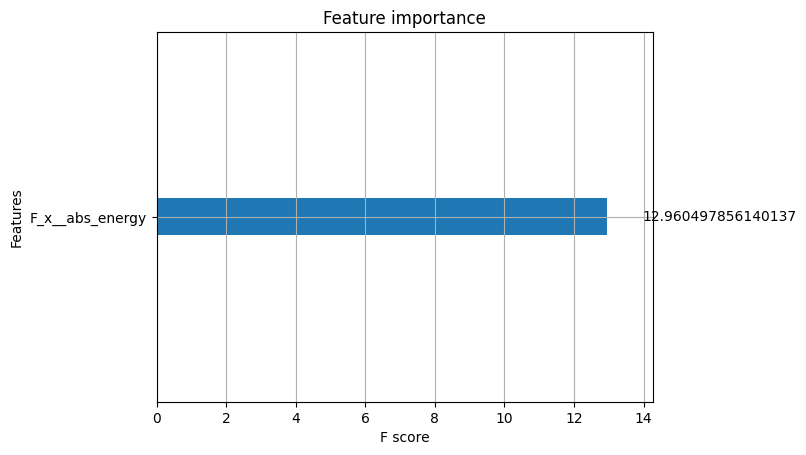

In [32]:
# 9: XGBoost plot_importance 확인 및 시각화
xgb.plot_importance(xgb_clf, importance_type = 'gain') # plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인한다.
plt.show()

- 위 그래프 결과, F_x_abs_energy라는 피처가 가장 중요한 역할을 했다.
- 따라서, 결국 고장 유무를 판별하는 기준은 F_x_abs_energy라는 특징 1개였음을 알 수 있다.

In [33]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미하다.

np.int64(1)

- feature_importances_를 통해 0이 아닌값이 1개가 있다는 것을 알 수 있다.


##### 3) Light GBM
- Light GBM은 내부적으로 자동으로 피처를 생성하면서, 피처 이름에 복잡한 특수문자를 포함한다. JSON에서는 ', ", [] 등의 특수문자를 문법적으로 중요한 기호로 인식을 하는데, 이것이 Light GBM에서 에러를 유발하기 때문에 아래와 같은 코드로 별도로 처리해야 한다!

In [42]:
def clean_column_names(df):
    df.columns = [
        col.replace(' ', '_')
           .replace('(', '')
           .replace(')', '')
           .replace('[', '')
           .replace(']', '')
           .replace('{', '')
           .replace('}', '')
           .replace('"', '')
           .replace("'", '')
           .replace("=", '_')
           .replace(",", '_')
           .replace("__", "_")  # 중복 언더스코어 정리
        for col in df.columns
    ]
    return df

# 피처 이름 정리 적용
comprehensive_features_train = clean_column_names(comprehensive_features_train)
comprehensive_features_test = clean_column_names(comprehensive_features_test)

In [88]:
import lightgbm as lgb

lgbm_clf = lgb.LGBMClassifier(n_estimators=10, max_depth=3) # 모델 만들고
lgbm_clf.fit(comprehensive_features_train, y_train) # 학습하고

print("테스트 데이터 정확도:", lgbm_clf.score(comprehensive_features_test, y_test)) # score을 사용하여 예측 -> 평가 동시에 진행하기

[LightGBM] [Info] Number of positive: 16, number of negative: 51
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35684
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 1842
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238806 -> initscore=-1.159237
[LightGBM] [Info] Start training from score -1.159237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

##### 4) GBM

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_clf = GradientBoostingClassifier(n_estimators=10, max_depth=3) # 모델 만들고
gbm_clf.fit(comprehensive_features_train, y_train) # 학습하고

print("테스트 데이터 정확도:", gbm_clf.score(comprehensive_features_test, y_test)) # score을 사용하여 예측 -> 평가 동시에 진행하기

테스트 데이터 정확도: 1.0


##### 5) 로지스틱 회귀

In [99]:
from sklearn.linear_model import LogisticRegression


log_clf = LogisticRegression(max_iter=1000, random_state=42) # 모델 만들고
log_clf.fit(comprehensive_features_train, y_train) # 학습하고

print("테스트 데이터 정확도:", log_clf.score(comprehensive_features_test, y_test)) # score을 사용하여 예측 -> 평가 동시에 진행하기

테스트 데이터 정확도: 0.5714285714285714


##### 6) 모델 평가하기

In [84]:
# 10 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}

평가지표 해석 **(튜닝 전)**
- True 클래스
  - 정밀도(precision): 1.0 -> True로 예측한 것 중, 100%가 실제로 True임
  - 재현율(recall): 1.0 -> 실제 True 중 100%를 맞춤
  - f1-score: 1.0 -> 정밀도와 재현율 모두 1.0으로 완벽하므로, f1-score도 완벽함
  - support: 16 -> 실제 True인 데이터의 수
- False 클래스
  - 정밀도(precision): 1.0 -> False로 예측한 것 중, 100%가 실제로 False임
  - 재현율(recall): 1.0 -> 실제 False 중 100%를 맞춤
  - f1-score: 1.0
  - support: 5 -> 실제 False인 데이터의 수


전체 성능
- Accuracy(정확도): 전체 데이터 21개를 모두 정확하게 예측함
- Macro Average(평균): True, False 두개의 클래스의 평균
- Weighted Average(가중평균): 클래스의 샘플 수 비율을 고려한 평균

#### 7) 하이퍼파라미터 튜닝하기

##### 1) 랜덤포레스트

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 파라미터 설정
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, None]
}

# 모델과 그리드서치 설정
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 학습
grid_search.fit(comprehensive_features_train, y_train)

# 최적 모델로 예측 정확도 출력
best_rf = grid_search.best_estimator_

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("테스트 데이터 정확도:", best_rf.score(comprehensive_features_test, y_test))

최적 하이퍼파라미터: {'max_depth': 3, 'n_estimators': 10}
테스트 데이터 정확도: 0.8095238095238095


##### 2) XGBoost
- 굳이 튜닝할 필요 없음! -> 정확도가 1.0으로 고정된듯(?)

##### 3) Light GBM
- 굳이 튜닝할 필요 없음! -> 마찬가지의 이유

##### 4) GBM


In [91]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# 파라미터 설정
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# 모델과 그리드서치 설정
gbm_clf = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbm_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 학습
grid_search.fit(comprehensive_features_train, y_train)  # 학습하고

# 최적 모델로 예측 정확도 출력
best_gbm = grid_search.best_estimator_

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("테스트 데이터 정확도:", best_gbm.score(comprehensive_features_test, y_test))  # 평가

최적 하이퍼파라미터: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 10}
테스트 데이터 정확도: 0.9523809523809523


##### 5) 로지스틱 회귀

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 파라미터 설정
param_grid = {
    'C': [0.01, 0.1, 1, 10],           # 규제 강도 (작을수록 강한 규제)
    'penalty': ['l2'],                # 정규화 방식 (l2 = Ridge)
    'solver': ['lbfgs', 'liblinear']  # 최적화 알고리즘
}

# 모델과 그리드서치 설정
log_clf = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 학습
grid_search.fit(comprehensive_features_train, y_train)

# 최적 모델로 예측 정확도 출력
best_log = grid_search.best_estimator_

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("테스트 데이터 정확도:", best_log.score(comprehensive_features_test, y_test))

최적 하이퍼파라미터: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
테스트 데이터 정확도: 0.47619047619047616
